## SWOT Level 4 Altimetry Data Processing
### Open data from the cloud

In [2]:
import fsspec
import xarray as xr
import s3fs
import glob
import matplotlib.pyplot as plt
import copernicusmarine
import numpy as np

In [3]:
url = 'gs://pilot-hubs-scratch-ohw/miost/science'
fs, path = fsspec.url_to_fs(url)

In [4]:
fs.ls(path)[:10]

['pilot-hubs-scratch-ohw/miost/science/',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230710_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230711_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230712_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230713_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230714_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230715_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230716_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230717_20240501.nc',
 'pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230718_20240501.nc']

### Plot absolute dynamic topography for one day

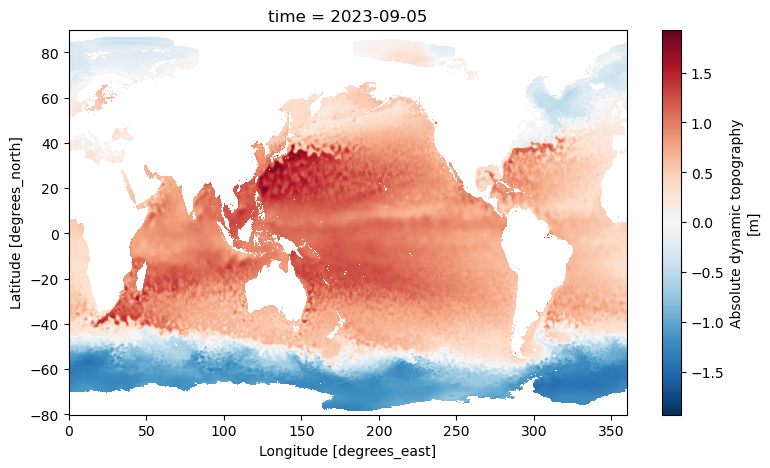

In [5]:
plt.figure(figsize=(9,5))

with fs.open('pilot-hubs-scratch-ohw/miost/science/dt_global_allsat_phy_l4_20230905_20240501.nc') as file:
    ds = xr.open_dataset(file, engine='h5netcdf')
    ds['adt'].plot()

### Open files

We selected a single day, but this could be used for opening data for a specific time period.

In [6]:
opened_files = []
for path in fs.ls(path):
    if '.nc' and '20230801' in path:     # changing the date here will open data from any day between july 10th and november 30th 2023
        opened_files.append(fs.open(path)) 
swot = xr.open_mfdataset(opened_files)

### Select square region for model input

In [7]:
swot = swot.sel(
    longitude=slice(13,17),
    latitude=slice(-40,-36),
)

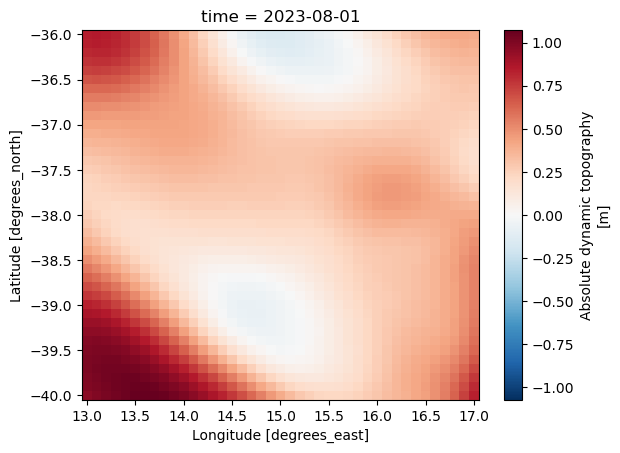

In [8]:
swot['adt'].plot()

### Smooth data for downgrading

In [9]:
swot_smoothed = swot.rolling(latitude=3, longitude=3, center=True).mean()

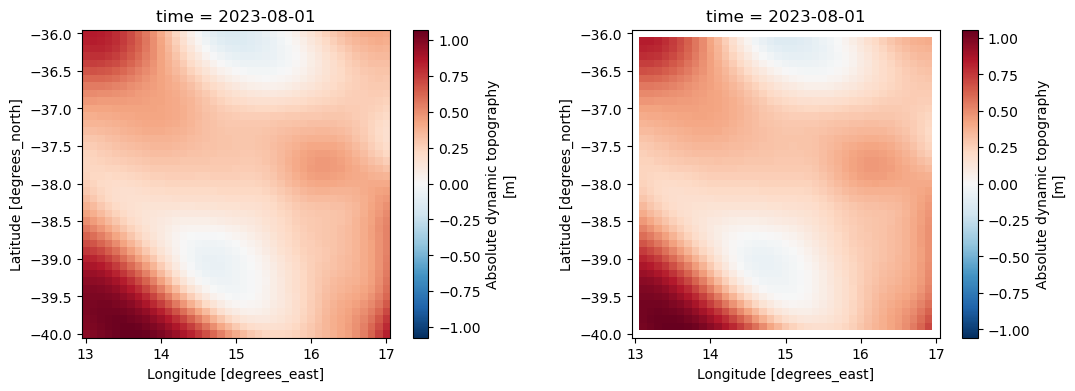

In [10]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(13,4),
)

ax1.set_aspect('equal')
swot['adt'].plot(ax=ax1)

ax2.set_aspect('equal')
swot_smoothed['adt'].plot(ax=ax2)

### Access AVISO data

Here we are using the AVISO data for the same time period of the SWOT data to validate the Level 4 interpolation.

In [11]:
def copernicus(ID,lon,lat,time,var,username='pwalfir',password='PedroW100%'):
        # Set parameters
    data_request = {
       "dataset" : ID,
       "longitude" : lon, 
       "latitude" : lat,
       "time" : time,
       "variables" : var
    }

    # Load xarray dataset
    dat = copernicusmarine.open_dataset(
        dataset_id = data_request["dataset"],
        minimum_longitude = data_request["longitude"][0],
        maximum_longitude = data_request["longitude"][1],
        minimum_latitude = data_request["latitude"][0],
        maximum_latitude = data_request["latitude"][1],
        start_datetime = data_request["time"][0],
        end_datetime = data_request["time"][1],
        variables = data_request["variables"],
        username  = username,
        password = password
    )
    return dat

In [12]:
aviso = copernicus(
    "cmems_obs-sl_glo_phy-ssh_myint_allsat-l4-duacs-0.25deg_P1D",
    [13,17],
    [-40,-36],
    ["2023-08-01", "2023-08-31"],
    ["adt"]
)

INFO - 2024-08-30T17:34:16Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-30T17:34:16Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-30T17:34:19Z - Service was not specified, the default one was selected: "arco-time-series"


### Interpolate SWOT data on AVISO grid

In [13]:
swot_interp_aviso = swot_smoothed.interp_like(aviso.isel(time=0))

In [14]:
residue = swot_interp_aviso['adt'] - aviso.isel(time=0)['adt']

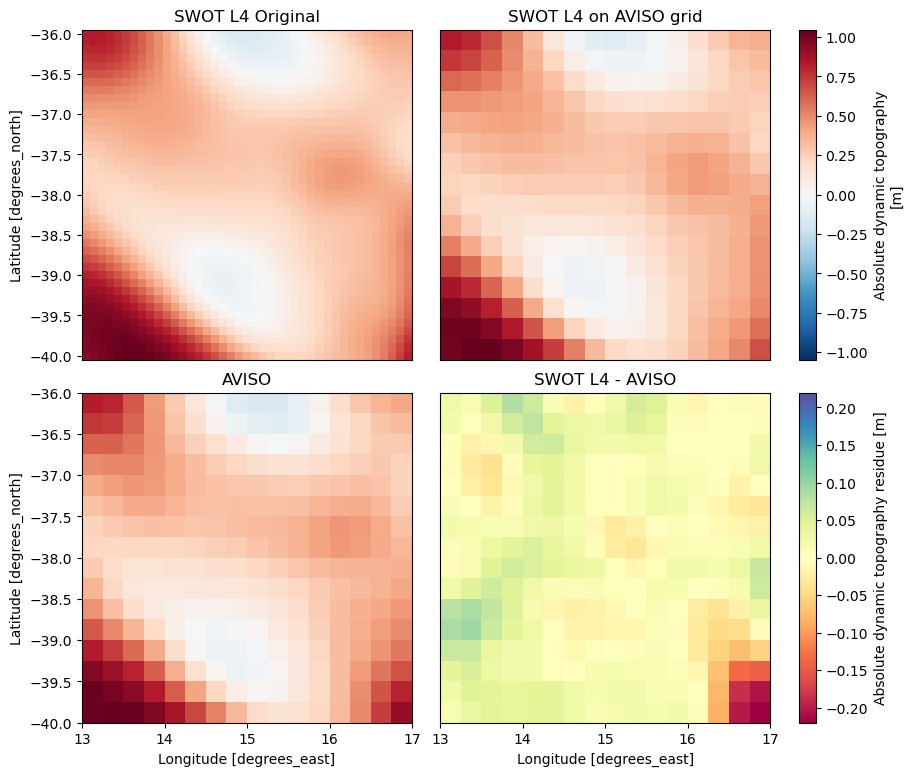

In [15]:
# adding and adjusting subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12,9),
)
fig.subplots_adjust(hspace=.1, wspace=-.4)


# top left axis
ax1.set_aspect('equal')
swot['adt'].plot(ax=ax1, add_colorbar=False)

ax1.set_title('SWOT L4 Original')
ax1.set_xticks([])
ax1.set_xlabel('')


# top right axis
ax2.set_aspect('equal')
swot_interp_aviso['adt'].plot(ax=ax2)

ax2.set_title('SWOT L4 on AVISO grid')
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')


# bottom left axis
ax3.set_aspect('equal')
aviso.isel(time=0)['adt'].plot(ax=ax3, add_colorbar=False)

ax3.set_title('AVISO')


# bottom right axis
ax4.set_aspect('equal')
residue.plot(ax=ax4, cmap='Spectral', cbar_kwargs={'label':'Absolute dynamic topography residue [m]'})

ax4.set_title('SWOT L4 - AVISO')
ax4.set_yticks([])
ax4.set_ylabel('')

plt.savefig('swot_validation.png', bbox_inches='tight')

### Interpolate SWOT data to GLORYS resolution

In [20]:
newlat = np.arange(
    aviso.latitude.min(),
    aviso.latitude.max()+(1/12),
    1/12,
)
newlon = np.arange(
    aviso.longitude.min(),
    aviso.longitude.max()+(1/12),
    1/12,
)

In [21]:
swot_interp_glorys = swot.interp(
    latitude=newlat,
    longitude=newlon,
)

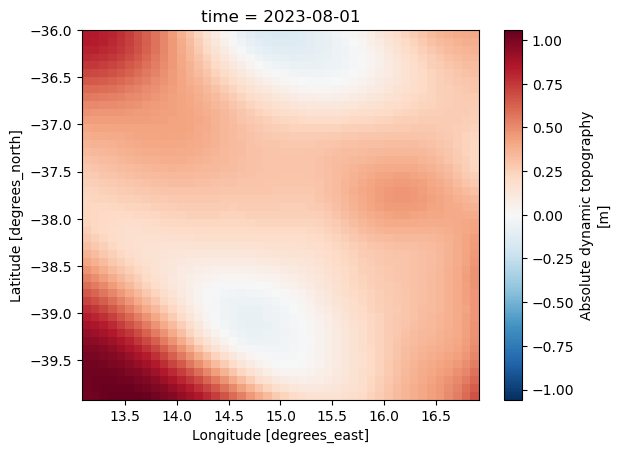

In [22]:
swot_interp_glorys['adt'].plot()